## Import Libraries & Setup

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy import interpolate


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")

Libraries imported successfully!


##  Load Data

In [10]:

train_dtypes = {
    'store_nbr': 'int8',
    'item_nbr': 'int32', 
    'unit_sales': 'float32',
    'onpromotion': 'boolean'
}

try:
    train = pd.read_csv('train.csv', dtype=train_dtypes, parse_dates=['date'])
    print(f"Loaded train: {train.shape}")
except MemoryError:
    print("Memory error - loading in chunks...")
    
    def load_train_chunks(chunk_size=100000, max_rows=2000000):
        chunks = []
        rows_read = 0
        
        try:
            for chunk in pd.read_csv('train.csv', dtype=train_dtypes, 
                                   parse_dates=['date'], chunksize=chunk_size):
                chunks.append(chunk)
                rows_read += len(chunk)
                
                if rows_read >= max_rows:
                    break
            
            return pd.concat(chunks, ignore_index=True)
        
        except MemoryError:
            if chunks:
                return pd.concat(chunks[:5], ignore_index=True)
            else:
                return pd.read_csv('train.csv', dtype=train_dtypes, 
                                 parse_dates=['date'], nrows=100000)
    
    train = load_train_chunks()

# test = pd.read_csv('test.csv')
# sample_submission = pd.read_csv('sample_submission.csv')
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
oil = pd.read_csv('oil.csv')
# holidays = pd.read_csv('holidays_events.csv')
# transactions = pd.read_csv('transactions.csv')




Loaded train: (125497040, 6)


In [7]:
# Rozszerzenie train o cechy produktowe i sklepowe (product & business level)
def create_extend_train(train, items, stores):
    """
    Dołącza do train cechy produktowe (family, class) oraz sklepowe (city, state).
    """
    items_cols = ['item_nbr', 'family', 'class']
    items_sel = items[items_cols].drop_duplicates('item_nbr')
    stores_cols = ['store_nbr', 'city', 'state']
    stores_sel = stores[stores_cols].drop_duplicates('store_nbr')
    # Joinuj do train
    train_ext = train.merge(items_sel, on='item_nbr', how='left')
    train_ext = train_ext.merge(stores_sel, on='store_nbr', how='left')
    return train_ext

train = create_extend_train(train, items, stores)
# Podgląd efektu
print('Po rozszerzeniu train:', train.shape)
display(train.head(3))

Po rozszerzeniu train: (125497040, 10)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,city,state
0,0,2013-01-01,25,103665,7.0,<NA>,BREAD/BAKERY,2712,Salinas,Santa Elena
1,1,2013-01-01,25,105574,1.0,<NA>,GROCERY I,1045,Salinas,Santa Elena
2,2,2013-01-01,25,105575,2.0,<NA>,GROCERY I,1045,Salinas,Santa Elena


## Initial Data Assessment

In [5]:

# Create datasets dictionary for analysis
datasets = {
    'train': train,
    'test': test, 
    'oil': oil,
    'stores': stores,
    'items': items,
    'holidays': holidays,
    'transactions': transactions
}

print("MISSING VALUES:")

for name, df in datasets.items():
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    if missing.sum() > 0:
        print(f"\n{name.upper()}:")
        for col, count in missing[missing > 0].items():
            pct = missing_pct[col]
            print(f"   {col:15}: {count:,} ({pct}%)")





MISSING VALUES:

TRAIN:
   onpromotion    : 21,657,651 (17.26%)

OIL:
   dcoilwtico     : 43 (3.53%)

TRAIN:
   onpromotion    : 21,657,651 (17.26%)

OIL:
   dcoilwtico     : 43 (3.53%)


---
# TASK 1: DATA CLEANING
## Handle NaN Values

FILLING MISSING OIL PRICES WITH PCHIP INTERPOLATION:
Using PCHIP (Piecewise Cubic Hermite Interpolation)...
Input data: 1175 known prices, 1218 total dates
PCHIP interpolation applied successfully
Remaining missing values: 0

PCHIP Imputation Summary:
   Original values: 1,175
   Imputed values:  43
   Total complete:  1,218
   Method: PCHIP (shape-preserving)


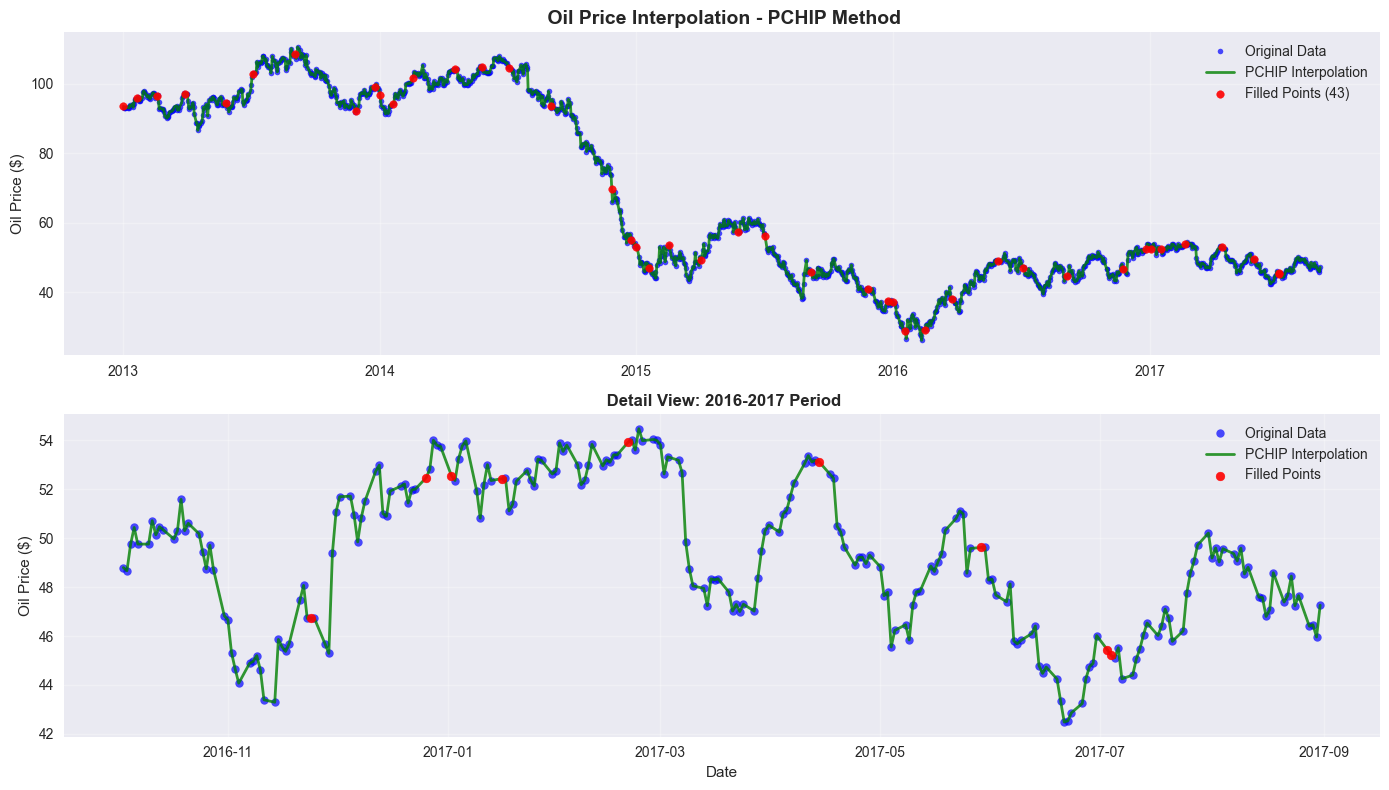


 FILLED VALUES STATISTICS:
   Count: 43
   Mean:  $66.80
   Std:   $26.04
   Range: $28.81 - $108.56

 QUALITY ASSESSMENT:
   Original data mean: $67.71
   Filled data mean:   $66.80
   Mean difference:    1.4% (should be <10%)
   Quality check: PASSED


In [6]:
# SOLUTION 1: PCHIP Interpolation for Oil Prices
print("FILLING MISSING OIL PRICES WITH PCHIP INTERPOLATION:")

oil_processed = oil.copy()

print("Using PCHIP (Piecewise Cubic Hermite Interpolation)...")

oil_processed['date'] = pd.to_datetime(oil_processed['date'])

oil_processed['date_numeric'] = (oil_processed['date'] - oil_processed['date'].min()).dt.days

non_null_mask = oil_processed['dcoilwtico'].notnull()
x_known = oil_processed.loc[non_null_mask, 'date_numeric'].values
y_known = oil_processed.loc[non_null_mask, 'dcoilwtico'].values
x_all = oil_processed['date_numeric'].values

print(f"Input data: {len(x_known)} known prices, {len(x_all)} total dates")

if len(x_known) >= 4:
    pchip_func = interpolate.PchipInterpolator(x_known, y_known)
    oil_processed['dcoilwtico_filled'] = pchip_func(x_all)
    print("PCHIP interpolation applied successfully")
else:
    oil_processed['dcoilwtico_filled'] = oil_processed['dcoilwtico'].interpolate(method='linear')
    oil_processed['dcoilwtico_filled'] = oil_processed['dcoilwtico_filled'].fillna(method='bfill')
    print(" Insufficient points for PCHIP, used linear fallback")

filled_mask = oil_processed['dcoilwtico'].isnull()


remaining_nan = oil_processed['dcoilwtico_filled'].isnull().sum()
print(f"Remaining missing values: {remaining_nan}")

original_available = oil['dcoilwtico'].count()
filled_count = oil_processed['dcoilwtico_filled'].count()
imputed_count = filled_count - original_available

print(f"\nPCHIP Imputation Summary:")
print(f"   Original values: {original_available:,}")
print(f"   Imputed values:  {imputed_count:,}")
print(f"   Total complete:  {filled_count:,}")
print(f"   Method: PCHIP (shape-preserving)")

plt.figure(figsize=(14, 8))


plt.subplot(2, 1, 1)
plt.plot(oil_processed['date'], oil_processed['dcoilwtico'], 'o', alpha=0.7, label='Original Data', markersize=4, color='blue')
plt.plot(oil_processed['date'], oil_processed['dcoilwtico_filled'], '-', alpha=0.8, label='PCHIP Interpolation', linewidth=2, color='green')

if filled_mask.any():
    filled_dates = oil_processed.loc[filled_mask, 'date']
    plt.scatter(filled_dates, oil_processed.loc[filled_mask, 'dcoilwtico_filled'], 
               color='red', s=30, alpha=0.9, label=f'Filled Points ({filled_mask.sum()})', zorder=5)

plt.title(' Oil Price Interpolation - PCHIP Method', fontsize=14, fontweight='bold')
plt.ylabel('Oil Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 1, 2)
zoom_start = pd.Timestamp('2016-10-01')
zoom_end = pd.Timestamp('2017-12-31')
zoom_mask = (oil_processed['date'] >= zoom_start) & (oil_processed['date'] <= zoom_end)

plt.plot(oil_processed.loc[zoom_mask, 'date'], oil_processed.loc[zoom_mask, 'dcoilwtico'], 
         'o', alpha=0.7, label='Original Data', markersize=6, color='blue')
plt.plot(oil_processed.loc[zoom_mask, 'date'], oil_processed.loc[zoom_mask, 'dcoilwtico_filled'], 
         '-', alpha=0.8, label='PCHIP Interpolation', linewidth=2, color='green')

zoom_filled = zoom_mask & filled_mask
if zoom_filled.any():
    plt.scatter(oil_processed.loc[zoom_filled, 'date'], oil_processed.loc[zoom_filled, 'dcoilwtico_filled'], 
               color='red', s=40, alpha=0.9, label='Filled Points', zorder=5)

plt.title(' Detail View: 2016-2017 Period', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Oil Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


if filled_mask.any():
    filled_values = oil_processed.loc[filled_mask, 'dcoilwtico_filled']
    
    print(f"\n FILLED VALUES STATISTICS:")
    print(f"   Count: {len(filled_values):,}")
    print(f"   Mean:  ${filled_values.mean():.2f}")
    print(f"   Std:   ${filled_values.std():.2f}")
    print(f"   Range: ${filled_values.min():.2f} - ${filled_values.max():.2f}")
    
    # Quality check
    original_mean = oil_processed['dcoilwtico'].mean()
    filled_mean = filled_values.mean()
    mean_diff_pct = abs(filled_mean - original_mean) / original_mean * 100
    
    print(f"\n QUALITY ASSESSMENT:")
    print(f"   Original data mean: ${original_mean:.2f}")
    print(f"   Filled data mean:   ${filled_mean:.2f}")
    print(f"   Mean difference:    {mean_diff_pct:.1f}% (should be <10%)")
    
    if mean_diff_pct < 10:
        print("   Quality check: PASSED")
    else:
        print("   Quality check: Review needed")



In [7]:
df_missing = oil_processed[oil_processed['dcoilwtico'].isnull()][['date', 'dcoilwtico', 'dcoilwtico_filled']]
df_missing.head()

,date,dcoilwtico,dcoilwtico_filled
0,2013-01-01,NaN,93.610000
14,2013-01-21,NaN,96.037500
34,2013-02-18,NaN,96.574375
63,2013-03-29,NaN,97.218125
104,2013-05-27,NaN,94.523438


In [8]:
oil_processed['date'] = pd.to_datetime(oil_processed['date'])


oil_start = oil_processed['date'].min()
oil_end = oil_processed['date'].max()
complete_date_range = pd.date_range(start=oil_start, end=oil_end, freq='D')



oil_complete = pd.DataFrame({
    'date': complete_date_range
})


oil_complete = oil_complete.merge(oil_processed, on='date', how='left')


oil_complete['date_numeric'] = (oil_complete['date'] - oil_complete['date'].min()).dt.days


non_null_mask = oil_complete['dcoilwtico_filled'].notnull()
x_known = oil_complete.loc[non_null_mask, 'date_numeric'].values
y_known = oil_complete.loc[non_null_mask, 'dcoilwtico_filled'].values
x_all = oil_complete['date_numeric'].values

print(f"   PCHIP input: {len(x_known)} known prices → {len(x_all)} complete dates")

# Apply PCHIP interpolation for all missing dates
if len(x_known) >= 4:
    pchip_complete = interpolate.PchipInterpolator(x_known, y_known)
    oil_complete['dcoilwtico_complete'] = pchip_complete(x_all)
else:
    # Fallback to linear if insufficient data points
    oil_complete['dcoilwtico_complete'] = oil_complete['dcoilwtico_filled'].interpolate(method='linear')
    oil_complete['dcoilwtico_complete'] = oil_complete['dcoilwtico_complete'].fillna(method='bfill')
    oil_complete['dcoilwtico_complete'] = oil_complete['dcoilwtico_complete'].fillna(method='ffill')
    print("   Used linear fallback (insufficient points for PCHIP)")


oil_complete = oil_complete.drop('date_numeric', axis=1)


final_missing = oil_complete['dcoilwtico_complete'].isnull().sum()
original_available = oil_processed['dcoilwtico'].count()
total_filled = len(oil_complete) - original_available

# 6. Identyfikacja typów uzupełnionych danych
original_mask = oil_complete['dcoilwtico'].notnull()  # Oryginalne dane
holiday_mask = oil_complete['dcoilwtico'].isnull() & oil_complete['dcoilwtico_filled'].notnull()  # Święta (z API)
weekend_mask = oil_complete['dcoilwtico_filled'].isnull()  # Weekendy (nowe)


# 7. Aktualizacja zmiennej oil_processed
oil_processed = oil_complete.copy()
print(f"\nZaktualizowano oil_processed: {len(oil_processed):,} kompletnych rekordów!")

   PCHIP input: 1218 known prices → 1704 complete dates

Zaktualizowano oil_processed: 1,704 kompletnych rekordów!


In [9]:
oil_complete

,date,dcoilwtico,dcoilwtico_filled,dcoilwtico_complete
0,2013-01-01,NaN,93.61,93.610000
1,2013-01-02,93.14,93.14,93.140000
2,2013-01-03,92.97,92.97,92.970000
3,2013-01-04,93.12,93.12,93.120000
4,2013-01-05,NaN,NaN,93.160512
...,...,...,...,...
1699,2017-08-27,NaN,NaN,46.724074
1700,2017-08-28,46.40,46.40,46.400000
1701,2017-08-29,46.46,46.46,46.460000
1702,2017-08-30,45.96,45.96,45.960000


In [11]:
#wszystkie brakujące daty z oil i train w osobnych kolumnach, zjoinowane po pełnym zakresie
oil_dates_raw = pd.to_datetime(oil['date'])
train_dates_raw = pd.to_datetime(train['date'])

all_dates = pd.date_range(start=min(oil_dates_raw.min(), train_dates_raw.min()), 
                        end=max(oil_dates_raw.max(), train_dates_raw.max()), freq='D')

oil_dates_set = set(oil_dates_raw)
train_dates_set = set(train_dates_raw)

missing_in_oil = [d for d in all_dates if d not in oil_dates_set]
missing_in_train = [d for d in all_dates if d not in train_dates_set]

df_missing = pd.DataFrame({'date': all_dates})
df_missing['missing_in_oil'] = df_missing['date'].isin(missing_in_oil)
df_missing['missing_in_train'] = df_missing['date'].isin(missing_in_train)

display(df_missing)

print(f"Liczba brakujących dat w oil: {df_missing['missing_in_oil'].sum()}")
print(f"Liczba brakujących dat w train: {df_missing['missing_in_train'].sum()}")
print(f"Liczba dat brakujących w obu: {(df_missing['missing_in_oil'] & df_missing['missing_in_train']).sum()}")

,date,missing_in_oil,missing_in_train
0,2013-01-01,False,False
1,2013-01-02,False,False
2,2013-01-03,False,False
3,2013-01-04,False,False
4,2013-01-05,True,False
...,...,...,...
1699,2017-08-27,True,True
1700,2017-08-28,False,True
1701,2017-08-29,False,True
1702,2017-08-30,False,True


Liczba brakujących dat w oil: 486
Liczba brakujących dat w train: 20
Liczba dat brakujących w obu: 5


In [ ]:
# Wyśbrakujące daty w szeregu czasowym train (każda data w osobnym wierszu)
train_min_date = train['date'].min() if 'train' in locals() else None
train_max_date = train['date'].max() if 'train' in locals() else None
if train_min_date is not None and train_max_date is not None:
    pelny_zakres_train = pd.date_range(start=train_min_date, end=train_max_date, freq='D')
    daty_train = set(pd.to_datetime(train['date']))
    brakujace_dat_train = [d for d in pelny_zakres_train if d not in daty_train]
    brakujace_dat_train_df = pd.DataFrame({'brakujaca_data': brakujace_dat_train})
    display(brakujace_dat_train_df)
    print(f'Liczba brakujących dat w szeregu czasowym train: {len(brakujace_dat_train)}')
else:
    print('Brak danych o zakresie dat w train.')

,brakujaca_data
0,2013-12-25
1,2014-12-25
2,2015-12-25
3,2016-12-25


Liczba brakujących dat w szeregu czasowym train: 4


In [21]:
# Ile jest brakujących dat w oil, które NIE są brakujące w train?
oil_dates = set(pd.to_datetime(oil['date'])) if 'oil' in locals() else set()
train_dates = set(pd.to_datetime(train['date'])) if 'train' in locals() else set()
if oil_dates and train_dates:
    # Pełny zakres dat (wspólny dla obu zbiorów)
    wspolny_zakres = oil_dates | train_dates
    # Daty brakujące w oil
    brakujace_w_oil = wspolny_zakres - oil_dates
    # Daty brakujące w train
    brakujace_w_train = wspolny_zakres - train_dates
    # Interesują nas daty brakujące w oil, ale obecne w train
    brak_w_oil_nie_w_train = brakujace_w_oil - brakujace_w_train
    print(f'Liczba dat brakujących w oil, ale obecnych w train: {len(brak_w_oil_nie_w_train)}')
    if len(brak_w_oil_nie_w_train) > 0:
        print('Przykładowe daty:')
        print(sorted(list(brak_w_oil_nie_w_train))[:10])
else:
    print('Brak danych do porównania oil i train.')

Liczba dat brakujących w oil, ale obecnych w train: 481
Przykładowe daty:
[Timestamp('2013-01-05 00:00:00'), Timestamp('2013-01-06 00:00:00'), Timestamp('2013-01-12 00:00:00'), Timestamp('2013-01-13 00:00:00'), Timestamp('2013-01-19 00:00:00'), Timestamp('2013-01-20 00:00:00'), Timestamp('2013-01-26 00:00:00'), Timestamp('2013-01-27 00:00:00'), Timestamp('2013-02-02 00:00:00'), Timestamp('2013-02-03 00:00:00')]


In [19]:
# Sprawdzenie zakresu dat w train i oil
print("Zakres dat w train:")
print(f"  Od: {train['date'].min()}  Do: {train['date'].max()}")

print("Zakres dat w oil:")
print(f"  Od: {oil['date'].min()}  Do: {oil['date'].max()}")

Zakres dat w train:
  Od: 2013-01-01 00:00:00  Do: 2017-08-15 00:00:00
Zakres dat w oil:
  Od: 2013-01-01  Do: 2017-08-31
  Od: 2013-01-01 00:00:00  Do: 2017-08-15 00:00:00
Zakres dat w oil:
  Od: 2013-01-01  Do: 2017-08-31


## Promotion Data - Missing Values Strategy

In [4]:
def process_promotions_flexible(df, dataset_name, strategy="nan"):
    
    if 'onpromotion' not in df.columns:
        print(f"{dataset_name}: No onpromotion column found")
        return df
    
    df_processed = df.copy()
    original_nan = df_processed['onpromotion'].isnull().sum()
    
    print(f"\n🔧 {dataset_name} - Strategy: '{strategy}'")
    print(f"   Original NaN values: {original_nan:,}")
    
    if strategy == "nan":
        # Strategy 1: Keep NaN values (ideal for XGBoost/LightGBM)
        df_processed['onpromotion_processed'] = df_processed['onpromotion']
        remaining_nan = df_processed['onpromotion_processed'].isnull().sum()
        
        print(f"   Kept NaN values as separate category")
        print(f"   Final NaN count: {remaining_nan:,}")
        print(f"   Perfect for: XGBoost, LightGBM, CatBoost")
        
    elif strategy == "new_category":
        # Strategy 2: Replace NaN with new category
        NEW_CATEGORY = "NO_PROMO_INFO"
        
        # Convert to object type to allow string category
        df_processed['onpromotion_processed'] = df_processed['onpromotion'].astype('object')
        df_processed['onpromotion_processed'] = df_processed['onpromotion_processed'].fillna(NEW_CATEGORY)
        
        remaining_nan = df_processed['onpromotion_processed'].isnull().sum()
        category_count = (df_processed['onpromotion_processed'] == NEW_CATEGORY).sum()
        
        print(f"   Replaced NaN with '{NEW_CATEGORY}' category")
        print(f"   Final NaN count: {remaining_nan:,}")
        print(f"   New category count: {category_count:,}")
        print(f"   Perfect for: All ML models, categorical encoding")
        
    else:
        raise ValueError(f"Unknown strategy: {strategy}. Use 'nan' or 'new_category'")
    
    return df_processed

print("DEMONSTRATION OF BOTH STRATEGIES:")

# Strategy 1: Keep NaN (best for Gradient Boosting)
train_nan = process_promotions_flexible(train, "TRAIN", strategy="nan")

# Strategy 2: New Category (universal approach)
train_category = process_promotions_flexible(train, "TRAIN", strategy="new_category")


print("Strategy 'nan':")
nan_stats = train_nan['onpromotion_processed'].value_counts(dropna=False)
for value, count in nan_stats.items():
    pct = (count / len(train_nan) * 100)
    print(f"   {str(value):15}: {count:,} ({pct:.1f}%)")

print(f"\nStrategy 'new_category':")
category_stats = train_category['onpromotion_processed'].value_counts(dropna=False)
for value, count in category_stats.items():
    pct = (count / len(train_category) * 100)
    print(f"   {str(value):15}: {count:,} ({pct:.1f}%)")


# Use NaN strategy as default (best for our target models)
train_processed = train_nan.copy()

print(f"\nDATASETS PREPARED:")
print(f"   Train (nan strategy): {len(train_processed):,} rows")


DEMONSTRATION OF BOTH STRATEGIES:

🔧 TRAIN - Strategy: 'nan'
   Original NaN values: 21,657,651

🔧 TRAIN - Strategy: 'nan'
   Original NaN values: 21,657,651
   Kept NaN values as separate category
   Final NaN count: 21,657,651
   Perfect for: XGBoost, LightGBM, CatBoost
   Kept NaN values as separate category
   Final NaN count: 21,657,651
   Perfect for: XGBoost, LightGBM, CatBoost

🔧 TRAIN - Strategy: 'new_category'
   Original NaN values: 21,657,651

🔧 TRAIN - Strategy: 'new_category'
   Original NaN values: 21,657,651
   Replaced NaN with 'NO_PROMO_INFO' category
   Final NaN count: 0
   New category count: 21,657,651
   Perfect for: All ML models, categorical encoding
Strategy 'nan':
   Replaced NaN with 'NO_PROMO_INFO' category
   Final NaN count: 0
   New category count: 21,657,651
   Perfect for: All ML models, categorical encoding
Strategy 'nan':
   False          : 96,028,767 (76.5%)
   <NA>           : 21,657,651 (17.3%)
   True           : 7,810,622 (6.2%)

Strategy 'new_

In [5]:
train_category

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,onpromotion_processed
0,0,2013-01-01,25,103665,7.0,<NA>,NO_PROMO_INFO
1,1,2013-01-01,25,105574,1.0,<NA>,NO_PROMO_INFO
2,2,2013-01-01,25,105575,2.0,<NA>,NO_PROMO_INFO
3,3,2013-01-01,25,108079,1.0,<NA>,NO_PROMO_INFO
4,4,2013-01-01,25,108701,1.0,<NA>,NO_PROMO_INFO
...,...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False,False
125497036,125497036,2017-08-15,54,2106464,1.0,True,True
125497037,125497037,2017-08-15,54,2110456,192.0,False,False
125497038,125497038,2017-08-15,54,2113914,198.0,True,True


---
#  TASK 2: DATE FEATURES
## Extract Temporal Features

In [11]:
# TASK 2: DATE FEATURES ENGINEERING (CLEAN VERSION)
def extract_comprehensive_date_features(df, date_column='date'):
    df_processed = df.copy()
    df_processed[date_column] = pd.to_datetime(df_processed[date_column])
    df_processed['day_in_the_month'] = df_processed[date_column].dt.day
    df_processed['day_of_the_week'] = df_processed[date_column].dt.dayofweek
    df_processed['week_of_the_year'] = df_processed[date_column].dt.isocalendar().week
    df_processed['month'] = df_processed[date_column].dt.month
    df_processed['year'] = df_processed[date_column].dt.year
    df_processed['quarter'] = df_processed[date_column].dt.quarter
    df_processed['is_weekend'] = df_processed['day_of_the_week'].isin([5, 6])
    df_processed['is_month_start'] = df_processed[date_column].dt.is_month_start
    df_processed['is_month_end'] = df_processed[date_column].dt.is_month_end
    df_processed['is_quarter_start'] = df_processed[date_column].dt.is_quarter_start
    df_processed['is_quarter_end'] = df_processed[date_column].dt.is_quarter_end
    data_start = df_processed[date_column].min()
    df_processed['days_since_start'] = (df_processed[date_column] - data_start).dt.days
    features = ['day_in_the_month', 'day_of_the_week', 'week_of_the_year',
                'month', 'year', 'quarter', 'is_weekend', 'is_month_start',
                'is_month_end', 'is_quarter_start', 'is_quarter_end', 'days_since_start']
    return df_processed, features

# Apply to all datasets with date columns
if 'train_processed' in locals():
    train_with_dates, date_features = extract_comprehensive_date_features(train_processed)
if 'oil_processed' in locals():
    oil_with_dates, _ = extract_comprehensive_date_features(oil_processed)
if 'transactions' in locals():
    transactions_with_dates, _ = extract_comprehensive_date_features(transactions)
if 'holidays' in locals():
    holidays_with_dates, _ = extract_comprehensive_date_features(holidays)


In [12]:
if 'train_with_dates' in locals() and 'date_features' in locals():
    
    print(f"Dataset size: {len(train_with_dates):,} rows")
    
    # Show sample of created features
    print("\nSAMPLE OF EXTRACTED DATE FEATURES:")
    sample_cols = ['date'] + date_features
    sample_data = train_with_dates[sample_cols].head(5)
    print(sample_data.to_string(index=False))
    
    # Quick feature verification
    print(f"\nCREATED FEATURES ({len(date_features)} total):")
    
    # Numeric features
    numeric_features = ['day_in_the_month', 'day_of_the_week', 'week_of_the_year', 
                       'month', 'year', 'quarter', 'days_since_start']
    
    print("Numeric temporal features:")
    for feature in numeric_features:
        if feature in train_with_dates.columns:
            min_val = train_with_dates[feature].min()
            max_val = train_with_dates[feature].max()
            print(f"   {feature:18}: Range {min_val}-{max_val}")
    
    # Boolean features  
    boolean_features = ['is_weekend', 'is_month_start', 'is_month_end', 
                       'is_quarter_start', 'is_quarter_end']
    
    print("\nBoolean temporal features:")
    for feature in boolean_features:
        if feature in train_with_dates.columns:
            true_count = train_with_dates[feature].sum()
            print(f"   {feature:18}: {true_count:,} True values")
    

Dataset size: 125,497,040 rows

SAMPLE OF EXTRACTED DATE FEATURES:
      date  day_in_the_month  day_of_the_week  week_of_the_year  month  year  quarter  is_weekend  is_month_start  is_month_end  is_quarter_start  is_quarter_end  days_since_start
2013-01-01                 1                1                 1      1  2013        1       False            True         False              True           False                 0
2013-01-01                 1                1                 1      1  2013        1       False            True         False              True           False                 0
2013-01-01                 1                1                 1      1  2013        1       False            True         False              True           False                 0
2013-01-01                 1                1                 1      1  2013        1       False            True         False              True           False                 0
2013-01-01                 1     

---
# TASK 3: PROMO FEATURES
## Cechy związane z promocjami (na poziomie produkt-sklep)

- **days_since_last_promo**: liczba dni od ostatniej promocji dla danego produktu w sklepie.
- days_until_next_promo, rolling_promo_count, streak.

Poziom agregacji: ['store_nbr', 'item_nbr'].

In [ ]:

def add_days_since_last_promo_fast(df, group_cols=['store_nbr', 'item_nbr'], date_col='date', promo_col='onpromotion'):
    df_sorted = df.sort_values(group_cols + [date_col]).copy()
    promo_dates = df_sorted[date_col].where(df_sorted[promo_col] == True)
    last_promo_date = promo_dates.groupby([df_sorted[c] for c in group_cols]).ffill()
    df_sorted['days_since_last_promo'] = (df_sorted[date_col] - last_promo_date).dt.days
    df_sorted['days_since_last_promo'] = df_sorted['days_since_last_promo'].where(last_promo_date.notna(), np.nan)
    return df_sorted

if 'train' in locals():
    train_days_since = add_days_since_last_promo_fast(train)


In [4]:
if 'train_days_since' in locals():
    first_valid_idx = train_days_since['days_since_last_promo'].first_valid_index()
    if first_valid_idx is not None:
        display(train_days_since.loc[first_valid_idx:].head(10))
    else:
        print('Brak niepustych wartości days_since_last_promo')
else:
    print('train_days_since nie istnieje')

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,days_since_last_promo
48215054,48215054,2015-06-05,1,103520,6.0,True,0.0
48292892,48292892,2015-06-06,1,103520,3.0,False,1.0
48376852,48376852,2015-06-07,1,103520,1.0,False,2.0
48460971,48460971,2015-06-08,1,103520,5.0,True,0.0
48616189,48616189,2015-06-10,1,103520,3.0,False,2.0
48692419,48692419,2015-06-11,1,103520,11.0,True,0.0
48766336,48766336,2015-06-12,1,103520,6.0,True,0.0
48842580,48842580,2015-06-13,1,103520,1.0,False,1.0
49009529,49009529,2015-06-15,1,103520,2.0,False,3.0
49087818,49087818,2015-06-16,1,103520,3.0,False,4.0


In [5]:
def add_days_until_next_promo(df, group_cols=['store_nbr', 'item_nbr'], date_col='date', promo_col='onpromotion'):
    df_sorted = df.sort_values(group_cols + [date_col]).copy()
    promo_dates = df_sorted[date_col].where(df_sorted[promo_col] == True)
    next_promo_date = promo_dates.groupby([df_sorted[c] for c in group_cols]).bfill()
    df_sorted['days_until_next_promo'] = (next_promo_date - df_sorted[date_col]).dt.days
    df_sorted['days_until_next_promo'] = df_sorted['days_until_next_promo'].where(next_promo_date.notna(), np.nan)
    return df_sorted

if 'train' in locals():
    train_features = add_days_until_next_promo(train)

In [6]:

if 'train_features' in locals():
    first_valid_idx = train_features['days_until_next_promo'].first_valid_index()
    if first_valid_idx is not None:
        display(train_features.loc[first_valid_idx:].head(10))
    else:
        print('Brak niepustych wartości days_until_next_promo')
else:
    print('train_features nie istnieje')

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,days_until_next_promo
82354,82354,2013-01-04,1,103520,2.0,<NA>,882.0
122402,122402,2013-01-05,1,103520,3.0,<NA>,881.0
206809,206809,2013-01-07,1,103520,2.0,<NA>,879.0
246109,246109,2013-01-08,1,103520,6.0,<NA>,878.0
285240,285240,2013-01-09,1,103520,3.0,<NA>,877.0
324277,324277,2013-01-10,1,103520,1.0,<NA>,876.0
362635,362635,2013-01-11,1,103520,2.0,<NA>,875.0
401889,401889,2013-01-12,1,103520,1.0,<NA>,874.0
525527,525527,2013-01-15,1,103520,1.0,<NA>,871.0
565197,565197,2013-01-16,1,103520,3.0,<NA>,870.0


In [6]:
def add_promo_streak(df, group_cols=['store_nbr', 'item_nbr'], date_col='date', promo_col='onpromotion'):
    df_sorted = df.sort_values(group_cols + [date_col]).copy()
    def streak_func(x):
        streak = (x != x.shift()).cumsum()
        return x.groupby(streak).cumcount() + 1
    mask = df_sorted[promo_col] == True
    df_sorted['promo_streak'] = 0
    df_sorted.loc[mask, 'promo_streak'] = (
        df_sorted[mask].groupby(group_cols)['onpromotion'].apply(streak_func).values
    )
    return df_sorted

if 'train' in locals():
    train_features = add_promo_streak(train)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,promo_streak
324276,324276,2013-01-10,1,96995,1.0,<NA>,0.0
362634,362634,2013-01-11,1,96995,1.0,<NA>,0.0
486204,486204,2013-01-14,1,96995,1.0,<NA>,0.0
644444,644444,2013-01-18,1,96995,2.0,<NA>,0.0
770056,770056,2013-01-21,1,96995,1.0,<NA>,0.0
...,...,...,...,...,...,...,...
125185373,125185373,2017-08-12,54,2116416,1.0,False,0.0
125291477,125291477,2017-08-13,54,2116416,2.0,False,0.0
125394227,125394227,2017-08-14,54,2116416,2.0,False,0.0
125497039,125497039,2017-08-15,54,2116416,2.0,False,0.0


In [9]:
# FEATURE: Czy w ciągu najbliższych 7 dni będzie promocja?
def add_promo_next_7days_flag(df, group_cols=['store_nbr', 'item_nbr'], date_col='date', promo_col='onpromotion', window=7):
    df_sorted = df.sort_values(group_cols + [date_col]).copy()
    future_promo = pd.DataFrame(0, index=df_sorted.index, columns=['future_promo'])
    for i in range(1, window+1):
        future_promo['future_promo'] += df_sorted.groupby(group_cols)[promo_col].shift(-i).fillna(False).astype(int)
    df_sorted['promo_in_next_7days'] = future_promo['future_promo'] > 0
    return df_sorted

if 'train' in locals():
    train_with_promo7 = add_promo_next_7days_flag(train)
    display(train_with_promo7.loc[train_with_promo7['promo_in_next_7days']].head(10))

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,city,state,promo_in_next_7days
47671748,47671748,2015-05-29,1,103520,2.0,False,GROCERY I,1028,Quito,Pichincha,True
47742446,47742446,2015-05-30,1,103520,1.0,False,GROCERY I,1028,Quito,Pichincha,True
47820201,47820201,2015-05-31,1,103520,1.0,False,GROCERY I,1028,Quito,Pichincha,True
47898037,47898037,2015-06-01,1,103520,2.0,False,GROCERY I,1028,Quito,Pichincha,True
47978890,47978890,2015-06-02,1,103520,1.0,False,GROCERY I,1028,Quito,Pichincha,True
48058958,48058958,2015-06-03,1,103520,1.0,False,GROCERY I,1028,Quito,Pichincha,True
48137957,48137957,2015-06-04,1,103520,5.0,False,GROCERY I,1028,Quito,Pichincha,True
48215054,48215054,2015-06-05,1,103520,6.0,True,GROCERY I,1028,Quito,Pichincha,True
48292892,48292892,2015-06-06,1,103520,3.0,False,GROCERY I,1028,Quito,Pichincha,True
48376852,48376852,2015-06-07,1,103520,1.0,False,GROCERY I,1028,Quito,Pichincha,True


In [10]:
if 'train' in locals():
    display(train_with_promo7[['date', 'store_nbr', 'item_nbr', 'onpromotion', 'promo_in_next_7days']].head(20))
    print(train_with_promo7['promo_in_next_7days'].value_counts())

,date,store_nbr,item_nbr,onpromotion,promo_in_next_7days
324276,2013-01-10,1,96995,<NA>,False
362634,2013-01-11,1,96995,<NA>,False
486204,2013-01-14,1,96995,<NA>,False
644444,2013-01-18,1,96995,<NA>,False
770056,2013-01-21,1,96995,<NA>,False
927560,2013-01-25,1,96995,<NA>,False
1052871,2013-01-28,1,96995,<NA>,False
1171957,2013-01-31,1,96995,<NA>,False
1384585,2013-02-05,1,96995,<NA>,False
1710821,2013-02-13,1,96995,<NA>,False


promo_in_next_7days
False    100399743
True      25097297
Name: count, dtype: int64
